# Support Vector Regression (SVR)

Algoritma Support Vector Regression 

# A. Menyiapkan Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# B. Memuat Data

In [2]:
data = pd.read_csv('final.csv')
data['datetime'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %H:%M:%S')
# sort data by datetime
# change datetime that has d/m/y 00:00:00, change to d+1/m/y 00:00:00
data['datetime'] = data['datetime'].apply(lambda x: x + pd.DateOffset(days=1) if x.strftime('%H:%M:%S') == '00:00:00' else x)
data = data.sort_values('datetime')

data

,datetime,choke,psig,apsig,oil,gas,water,liquid
0,2021-05-15 21:00:00,38,935,320,698.880,4.980,23.616,722.5
1,2021-05-15 21:15:00,38,935,321,822.456,4.988,32.592,855.0
2,2021-05-15 21:30:00,38,940,318,661.368,5.070,26.208,687.6
3,2021-05-15 21:45:00,38,938,317,737.664,5.061,29.232,766.9
4,2021-05-15 22:00:00,38,940,319,661.368,5.078,26.208,687.6
...,...,...,...,...,...,...,...,...
1873,2021-06-04 08:00:00,42,986,328,771.720,7.638,16.896,788.6
1874,2021-06-04 08:15:00,42,984,325,766.032,7.602,16.704,782.7
1875,2021-06-04 08:30:00,42,986,328,765.216,7.638,16.704,781.9
1876,2021-06-04 08:45:00,42,988,326,757.224,7.614,16.512,773.7


# C. Pemisahan Data Berdasarkan Nilai Choke
Termasuk menghapus kolom choke karena tidak diperlukan dalam pemodelan

## 1. Berapa choke yang ada dalam data?

In [3]:
data['choke'].value_counts()

choke
38    854
40    645
42    379
Name: count, dtype: int64

## 2. Memisahkan data berdasarkan nilai choke yang ada

In [4]:
data_38 = data[data['choke'] == 38].drop(['datetime', 'choke'], axis=1)
data_40 = data[data['choke'] == 40].drop(['datetime', 'choke'], axis=1)
data_42 = data[data['choke'] == 42].drop(['datetime', 'choke'], axis=1)

# Menampilkan Data
display('Data Choke 38', data_38.describe())
display('Data Choke 40', data_40.describe())
display('Data Choke 42', data_42.describe())

'Data Choke 38'

,psig,apsig,oil,gas,water,liquid
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,1007.033958,325.594848,761.594501,5.987358,17.394857,778.921077
std,73.533621,7.364072,45.464697,0.562406,7.202383,49.189237
min,835.000000,304.000000,610.704000,4.745000,6.144000,627.800000
25%,934.250000,320.000000,733.080000,5.279250,14.976000,747.400000
50%,1050.000000,328.000000,757.560000,6.267000,16.512000,775.100000
75%,1054.000000,331.000000,788.448000,6.384000,22.704000,812.225000
max,1067.000000,340.000000,893.448000,6.579000,48.000000,923.500000


'Data Choke 40'

,psig,apsig,oil,gas,water,liquid
count,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
mean,1021.804651,331.893023,767.669991,7.038047,15.788130,783.326512
std,5.367747,5.293207,27.692167,0.059675,3.047829,27.905772
min,1004.000000,318.000000,712.440000,6.888000,7.872000,728.000000
25%,1018.000000,327.000000,747.168000,7.000000,15.936000,763.200000
50%,1022.000000,334.000000,765.216000,7.038000,16.512000,781.100000
75%,1026.000000,336.000000,786.792000,7.077000,16.896000,803.900000
max,1039.000000,340.000000,839.832000,7.230000,31.920000,858.900000


'Data Choke 42'

,psig,apsig,oil,gas,water,liquid
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,988.068602,326.704485,800.717636,7.557427,17.555208,818.266755
std,4.861635,2.377642,16.509230,0.066787,1.365055,16.803696
min,982.000000,320.000000,757.224000,7.292000,9.024000,773.700000
25%,985.000000,325.000000,790.080000,7.544500,17.280000,807.400000
50%,986.000000,327.000000,800.400000,7.575000,17.472000,817.900000
75%,990.000000,328.000000,815.568000,7.599000,17.856000,833.400000
max,1018.000000,333.000000,845.280000,7.673000,27.072000,863.700000


# D. Normalisasi Data

## 1. Membuat fungsi untuk normalisasi data

In [5]:
def normalize_dataframe(df, method='min-max', range_min=0.0, range_max=1.0):
    # Normalisasi Data metode Min-Max
    # df: DataFrame
    # method: metode normalisasi, standard atau min-max
    # range_min: nilai minimum setelah normalisasi, only for min-max method
    # range_max: nilai maksimum setelah normalisasi, only for min-max method
    # return: DataFrame yang sudah dinormalisasi

    assert isinstance(df, pd.DataFrame), 'df harus bertipe DataFrame'

    # Membuat salinan DataFrame
    df_normalized = df.copy()

    if method == 'standard':
        # Normalisasi menggunakan metode standard
        df_normalized = (df - df.mean()) / df.std()
        
        return df_normalized
    
    #  Iterasi setiap kolom dalam DataFrame
    for column in df.columns:
        # Ambil nilai minimum dan maksimum dari kolom
        min_value = df[column].min()
        max_value = df[column].max()
        
        # Normalisasi setiap nilai dalam kolom
        df_normalized[column] = (df[column] - min_value) / (max_value - min_value) * (range_max - range_min) + range_min
    return df_normalized

## 2. Menormalisasi Data

In [6]:
data_38_normalized = normalize_dataframe(data_38, range_min=0.001)
data_40_normalized = normalize_dataframe(data_40, range_min=0.001)
data_42_normalized = normalize_dataframe(data_42, range_min=0.001)

# Menampilkan Data
display('Data Choke 38', data_38_normalized.describe())
display('Data Choke 40', data_40_normalized.describe())
display('Data Choke 42', data_42_normalized.describe())

'Data Choke 38'

,psig,apsig,oil,gas,water,liquid
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,0.741784,0.600257,0.534131,0.677726,0.269530,0.511551
std,0.316638,0.204353,0.160637,0.306349,0.171903,0.166182
min,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
25%,0.428374,0.445000,0.433383,0.292012,0.211798,0.405060
50%,0.926797,0.667000,0.519876,0.830050,0.248459,0.498642
75%,0.944022,0.750250,0.629011,0.893781,0.396247,0.624066
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


'Data Choke 40'

,psig,apsig,oil,gas,water,liquid
count,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
mean,0.509196,0.631870,0.434110,0.439294,0.329851,0.423240
std,0.153211,0.240360,0.217160,0.174313,0.126613,0.212971
min,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
25%,0.400600,0.409682,0.273335,0.328158,0.335994,0.269639
50%,0.514771,0.727545,0.414866,0.439158,0.359922,0.406248
75%,0.628943,0.818364,0.584064,0.553079,0.375874,0.580252
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


'Data Choke 42'

,psig,apsig,oil,gas,water,liquid
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,0.169404,0.516214,0.494438,0.696963,0.473223,0.495691
std,0.134910,0.182713,0.187298,0.175119,0.075559,0.186521
min,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
25%,0.084250,0.385231,0.373753,0.663067,0.457989,0.375070
50%,0.112000,0.538923,0.490834,0.743039,0.468617,0.491620
75%,0.223000,0.615769,0.662916,0.805969,0.489872,0.663670
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# E. Mengubah Data Series Menjadi Data Supervised

## 1. Membuat Fungsi untuk Membuat Data Supervised

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()

	columns = dff.columns

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		# names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		names += [(columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			# names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
			names += [(columns[j]+'(t)') for j in range(n_vars)]
		else:
			# names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
			names += [(columns[j]+'(t+%d)' % (i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## 2. Menggunakan Fungsi untuk Membuat Data Supervised

In [8]:
supervised_38 = series_to_supervised(data_38_normalized, 1, 1)
supervised_40 = series_to_supervised(data_40_normalized, 1, 1)
supervised_42 = series_to_supervised(data_42_normalized, 1, 1)

# Menampilkan Data
display('Data Choke 38', supervised_38.head())
display('Data Choke 40', supervised_40.head())
display('Data Choke 42', supervised_42.head())

'Data Choke 38'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1),psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
1,0.431603,0.44500,0.312546,0.129007,0.418014,0.320937,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578
2,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030
3,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939
4,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030
5,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030,0.461746,0.41725,0.359778,0.182389,0.527995,0.381748


'Data Choke 40'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1),psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
855,0.001000,0.772955,0.653324,0.450842,0.391826,0.648938,0.200800,0.909182,0.653324,0.544316,0.391826,0.648938
856,0.200800,0.909182,0.653324,0.544316,0.391826,0.648938,0.257886,0.818364,0.557903,0.480053,0.930210,0.655044
857,0.257886,0.818364,0.557903,0.480053,0.930210,0.655044,0.400600,0.727545,0.899121,0.652395,1.000000,1.000000
858,0.400600,0.727545,0.899121,0.652395,1.000000,1.000000,0.457686,1.000000,0.759472,1.000000,0.591228,0.788600
859,0.457686,1.000000,0.759472,1.000000,0.591228,0.788600,0.400600,1.000000,0.899121,0.921132,1.000000,1.000000


'Data Choke 42'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1),psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
1500,1.00000,0.615769,0.496824,0.184543,0.968117,0.59707,0.91675,0.462077,0.895989,0.124236,0.001000,0.79354
1501,0.91675,0.462077,0.895989,0.124236,0.001000,0.79354,0.83350,0.385231,0.996733,0.092772,0.006314,0.89344
1502,0.83350,0.385231,0.996733,0.092772,0.006314,0.89344,0.72250,0.154692,0.948539,0.001000,0.258721,0.89677
1503,0.72250,0.154692,0.948539,0.001000,0.258721,0.89677,0.77800,0.385231,1.000000,0.092772,0.521755,1.00000
1504,0.77800,0.385231,1.000000,0.092772,0.521755,1.00000,0.66700,0.154692,0.900073,0.105882,0.511128,0.90010


# F. Membagi Data Menjadi Data Training dan Data Testing

In [9]:
train_ratio = 0.8

train_length_38 = int(len(supervised_38) * train_ratio)
train_length_40 = int(len(supervised_40) * train_ratio)
train_length_42 = int(len(supervised_42) * train_ratio)

train_38_X = supervised_38.iloc[:train_length_38, :6]
train_38_y = supervised_38.iloc[:train_length_38, 6:]
test_38_X = supervised_38.iloc[train_length_38:, :6]
test_38_y = supervised_38.iloc[train_length_38:, 6:]

train_40_X = supervised_40.iloc[:train_length_40, :6]
train_40_y = supervised_40.iloc[:train_length_40, 6:]
test_40_X = supervised_40.iloc[train_length_40:, :6]
test_40_y = supervised_40.iloc[train_length_40:, 6:]

train_42_X = supervised_42.iloc[:train_length_42, :6]
train_42_y = supervised_42.iloc[:train_length_42, 6:]
test_42_X = supervised_42.iloc[train_length_42:, :6]
test_42_y = supervised_42.iloc[train_length_42:, 6:]

# Menampilkan Data
display('Data Choke 38', train_38_X.head(), train_38_y.head(), test_38_X.head(), test_38_y.head())

'Data Choke 38'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1)
1,0.431603,0.44500,0.312546,0.129007,0.418014,0.320937
2,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578
3,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030
4,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939
5,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030


,psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
1,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578
2,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030
3,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939
4,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030
5,0.461746,0.41725,0.359778,0.182389,0.527995,0.381748


,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1)
683,0.939716,0.63925,0.394037,0.903586,0.095515,0.353032
684,0.944022,0.69475,0.451699,0.914480,0.139623,0.414519
685,0.944022,0.69475,0.428125,0.914480,0.080049,0.383438
686,0.939716,0.69475,0.433383,0.914480,0.042243,0.383438
687,0.939716,0.66700,0.499186,0.909033,0.027350,0.444249


,psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
683,0.944022,0.69475,0.451699,0.914480,0.139623,0.414519
684,0.944022,0.69475,0.428125,0.914480,0.080049,0.383438
685,0.939716,0.69475,0.433383,0.914480,0.042243,0.383438
686,0.939716,0.66700,0.499186,0.909033,0.027350,0.444249
687,0.948328,0.66700,0.533529,0.909033,0.010165,0.474655


In [10]:
print("train_38_X shape: ", train_38_X.shape)
print("train_38_y shape: ", train_38_y.shape)
print("test_38_X shape: ", test_38_X.shape)
print("test_38_y shape: ", test_38_y.shape)

print("train_40_X shape: ", train_40_X.shape)
print("train_40_y shape: ", train_40_y.shape)
print("test_40_X shape: ", test_40_X.shape)
print("test_40_y shape: ", test_40_y.shape)

print("train_42_X shape: ", train_42_X.shape)
print("train_42_y shape: ", train_42_y.shape)
print("test_42_X shape: ", test_42_X.shape)
print("test_42_y shape: ", test_42_y.shape)

train_38_X shape:  (682, 6)
train_38_y shape:  (682, 6)
test_38_X shape:  (171, 6)
test_38_y shape:  (171, 6)
train_40_X shape:  (515, 6)
train_40_y shape:  (515, 6)
test_40_X shape:  (129, 6)
test_40_y shape:  (129, 6)
train_42_X shape:  (302, 6)
train_42_y shape:  (302, 6)
test_42_X shape:  (76, 6)
test_42_y shape:  (76, 6)


# G. Membangun Model SVR

In [11]:
from sklearn.linear_model import LinearRegression

# H. Melatih Model

## 1. Menentukan Hyperparameter

In [12]:
model_38 = LinearRegression()
model_40 = LinearRegression()
model_42 = LinearRegression()

## 2. Melatih Model

In [13]:
model_38.fit(train_38_X.values, train_38_y.values)
model_40.fit(train_40_X.values, train_40_y.values)
model_42.fit(train_42_X.values, train_42_y.values)

LinearRegression()

## 3. Melihat Grafik Loss

Loss Choke 38

In [14]:
# model_38.plot_loss()

Loss Choke 40

In [15]:
# model_40.plot_loss()

Loss Choke 42

In [16]:
# model_42.plot_loss()

# I. Evaluasi Model

In [17]:
# mse_38, rmse_38, mape_38, mape_per_c_38 = model_38.evaluate(test_38_X.values, test_38_y.values)
# mse_40, rmse_40, mape_40, mape_per_c_40 = model_40.evaluate(test_40_X.values, test_40_y.values)
# mse_42, rmse_42, mape_42, mape_per_c_41 = model_42.evaluate(test_42_X.values, test_42_y.values)

# print(f'MSE Choke 38: {mse_38}, RMSE Choke 38: {rmse_38}, MAPE Choke 38: {mape_38}, MAPE per column: {mape_per_c_38}')
# print(f'MSE Choke 40: {mse_40}, RMSE Choke 40: {rmse_40}, MAPE Choke 40: {mape_40}, MAPE per column: {mape_per_c_40}')
# print(f'MSE Choke 42: {mse_42}, RMSE Choke 42: {rmse_42}, MAPE Choke 42: {mape_42}, MAPE per column: {mape_per_c_41}')

# J. Prediksi Data

### 1. Data Uji

In [18]:
predictions_38 = model_38.predict(test_38_X.values)
predictions_40 = model_40.predict(test_40_X.values)
predictions_42 = model_42.predict(test_42_X.values)

### 2. Data Latih

In [19]:
predictions_train_38 = model_38.predict(train_38_X.values)
predictions_train_40 = model_40.predict(train_40_X.values)
predictions_train_42 = model_42.predict(train_42_X.values)

# K. Denormalisasi Data

## 1. Membuat Fungsi untuk Denormalisasi Data

In [20]:
def denormalize_dataframe(np_normalized, df_original):
    # Denormalisasi DataFrame menggunakan metode Min-Max
    # np_normalized: numpy array yang sudah dinormalisasi
    # df_original: DataFrame asli sebelum dinormalisasi
    # return: DataFrame yang sudah denormalisasi

    assert isinstance(df_original, pd.DataFrame), 'df_original harus bertipe DataFrame'
    assert isinstance(np_normalized, np.ndarray), 'np_normalized harus bertipe numpy array'

    # Membuat salinan DataFrame yang sudah dinormalisasi
    df_normalized = pd.DataFrame(np_normalized, columns=df_original.columns)
    
    # Iterasi setiap kolom dalam DataFrame
    for column in df_normalized.columns:
        # Ambil nilai minimum dan maksimum dari kolom
        min_value = df_original[column].min()
        max_value = df_original[column].max()
        
        # Denormalisasi setiap nilai dalam kolom
        df_normalized[column] = df_normalized[column] * (max_value - min_value) + min_value
        
    return df_normalized

## 2. Denormalisasi Data

In [21]:
denormalized_predictions_38 = denormalize_dataframe(predictions_38, data_38)
denormalized_predictions_40 = denormalize_dataframe(predictions_40, data_40)
denormalized_predictions_42 = denormalize_dataframe(predictions_42, data_42)

denormalized_predictions_train_38 = denormalize_dataframe(predictions_train_38, data_38)
denormalized_predictions_train_40 = denormalize_dataframe(predictions_train_40, data_40)
denormalized_predictions_train_42 = denormalize_dataframe(predictions_train_42, data_42)

denormalized_test_38_y = denormalize_dataframe(test_38_y.values, data_38)
denormalized_test_40_y = denormalize_dataframe(test_40_y.values, data_40)
denormalized_test_42_y = denormalize_dataframe(test_42_y.values, data_42)

denormalized_train_38_y = denormalize_dataframe(train_38_y.values, data_38)
denormalized_train_40_y = denormalize_dataframe(train_40_y.values, data_40)
denormalized_train_42_y = denormalize_dataframe(train_42_y.values, data_42)

# L. Visualisasi Data

## 1. Data Choke 38

In [22]:
import matplotlib.dates as mdates
# Define a function to format x-ticks for datetime
def format_date_ticks(ax, date_format='%Y/%m/%d %H:%M:%S'):
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))


/tmp/ipykernel_23319/2218385267.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


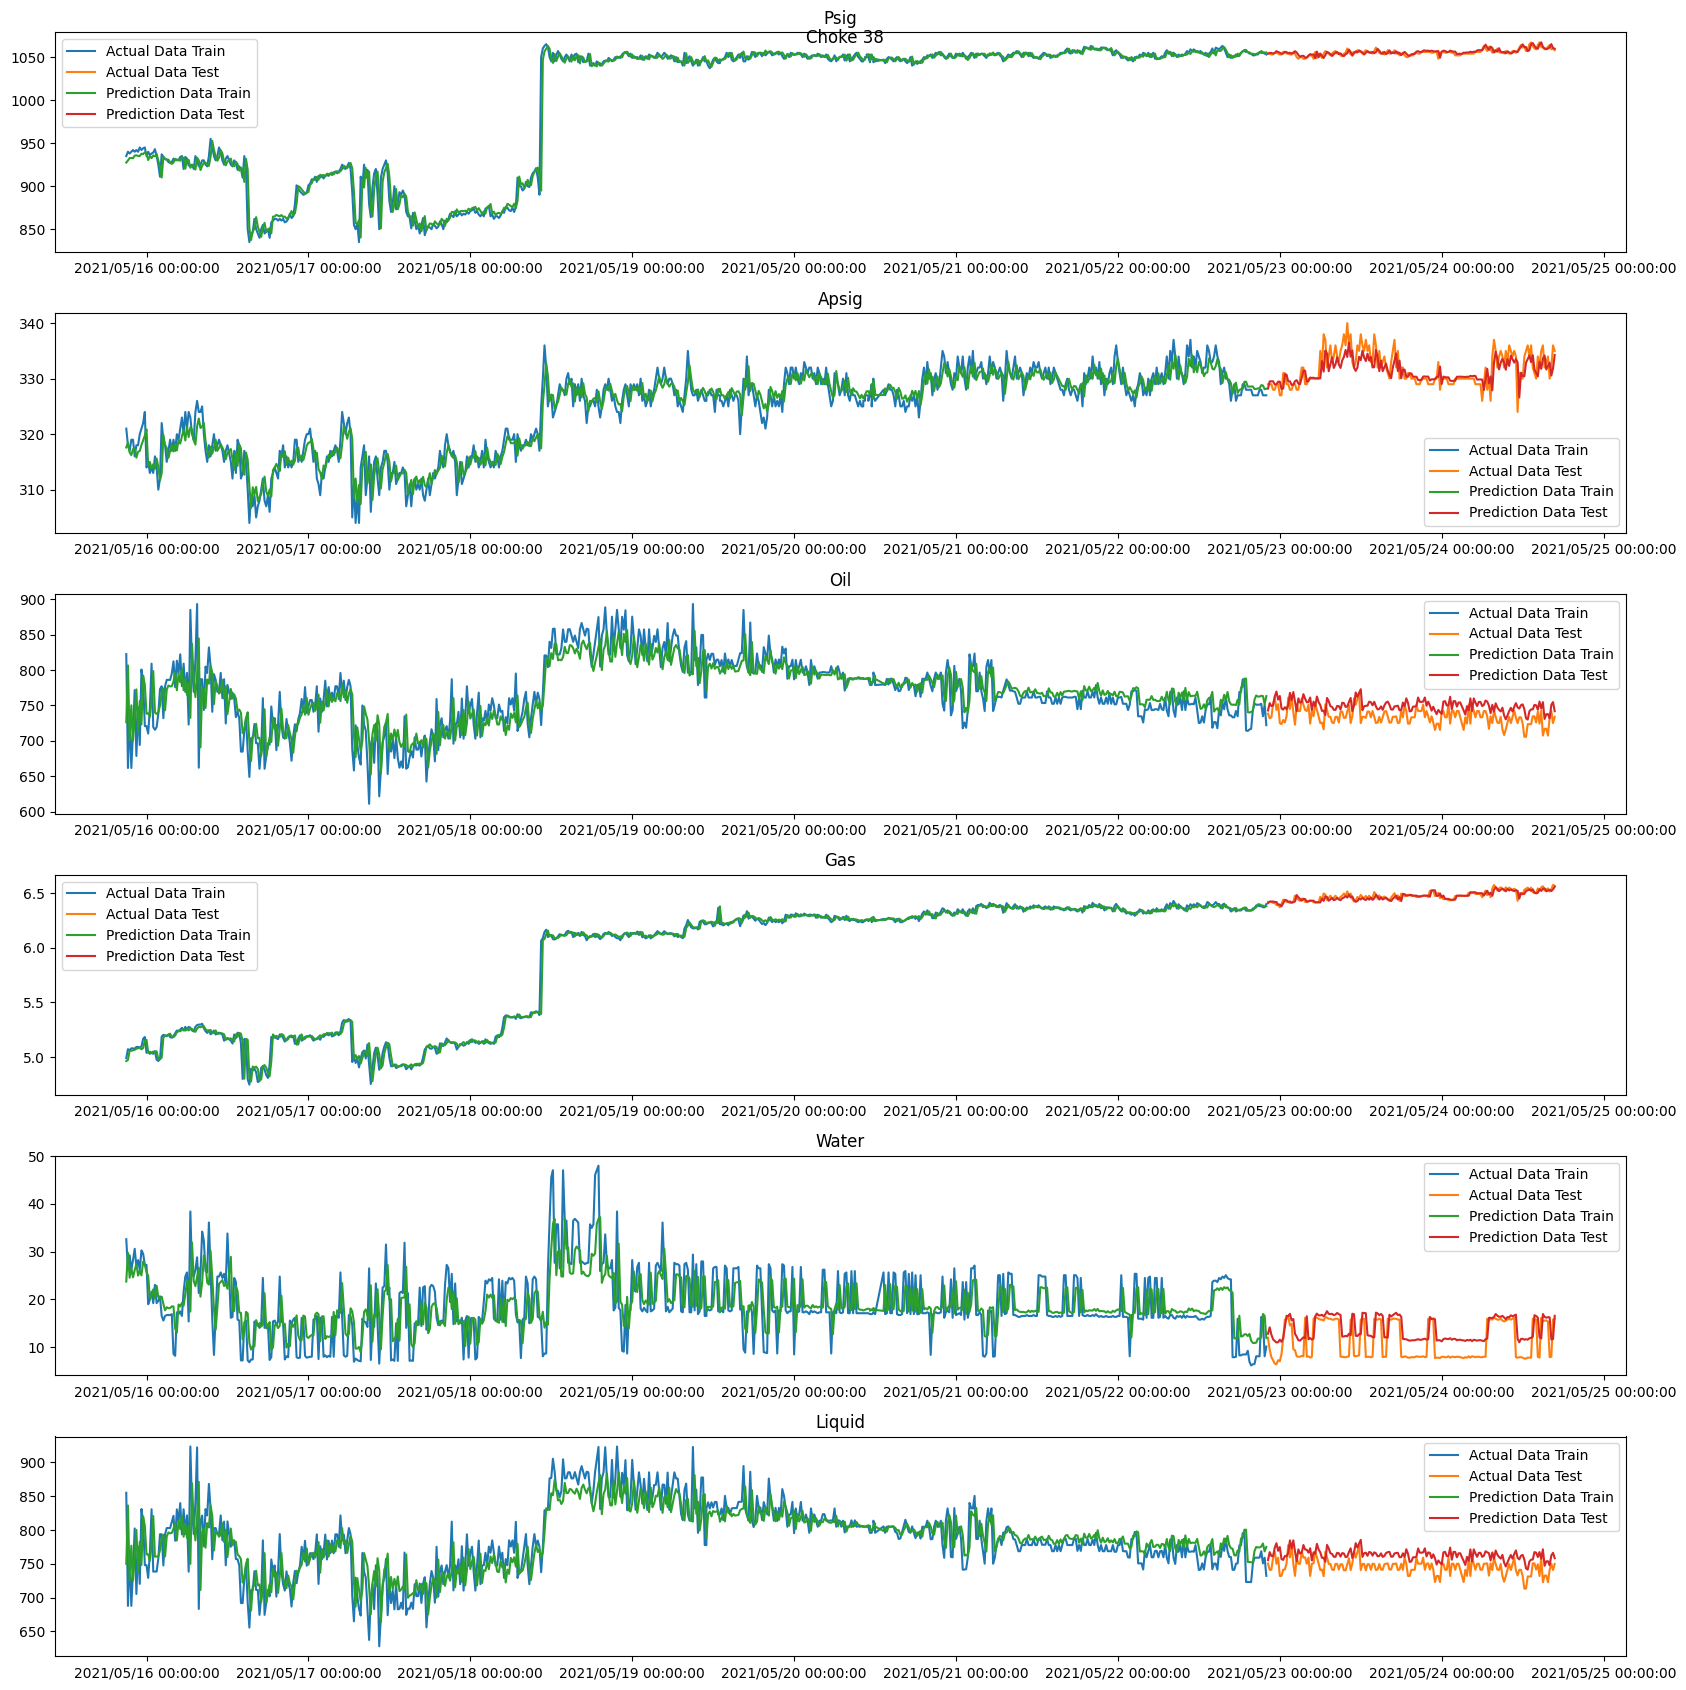

In [23]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_38_y.shape[1])

for i, ax in enumerate(axes):
    # Plot training data
    ax.plot(data['datetime'].iloc[:denormalized_train_38_y.shape[0]],
            denormalized_train_38_y.iloc[:, i], label='Actual Data Train')
    
    # Plot testing data
    ax.plot(data['datetime'].iloc[denormalized_train_38_y.shape[0]:denormalized_train_38_y.shape[0]+denormalized_test_38_y.shape[0]],
        denormalized_test_38_y.iloc[:, i], label='Actual Data Test')
    
    # Plot Prediction Training
    ax.plot(data['datetime'].iloc[:denormalized_train_38_y.shape[0]],
            denormalized_predictions_train_38.iloc[:, i], label='Prediction Data Train')
            
    # Plot predictions
    ax.plot(data['datetime'].iloc[denormalized_train_38_y.shape[0]:denormalized_train_38_y.shape[0]+denormalized_test_38_y.shape[0]],
            denormalized_predictions_38.iloc[:, i], label='Prediction Data Test')
    

    ax.set_title(denormalized_train_38_y.columns[i].capitalize())
    format_date_ticks(ax)
    ax.legend()

    # reset ticks every week data['datetime'] as xticks
    # ax.set_xticks(data.index)
    

plt.tight_layout()
fig.suptitle('Choke 38')
fig.savefig('choke_38.png')
fig.show()

## 2. Data Choke 40

/tmp/ipykernel_23319/394307312.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


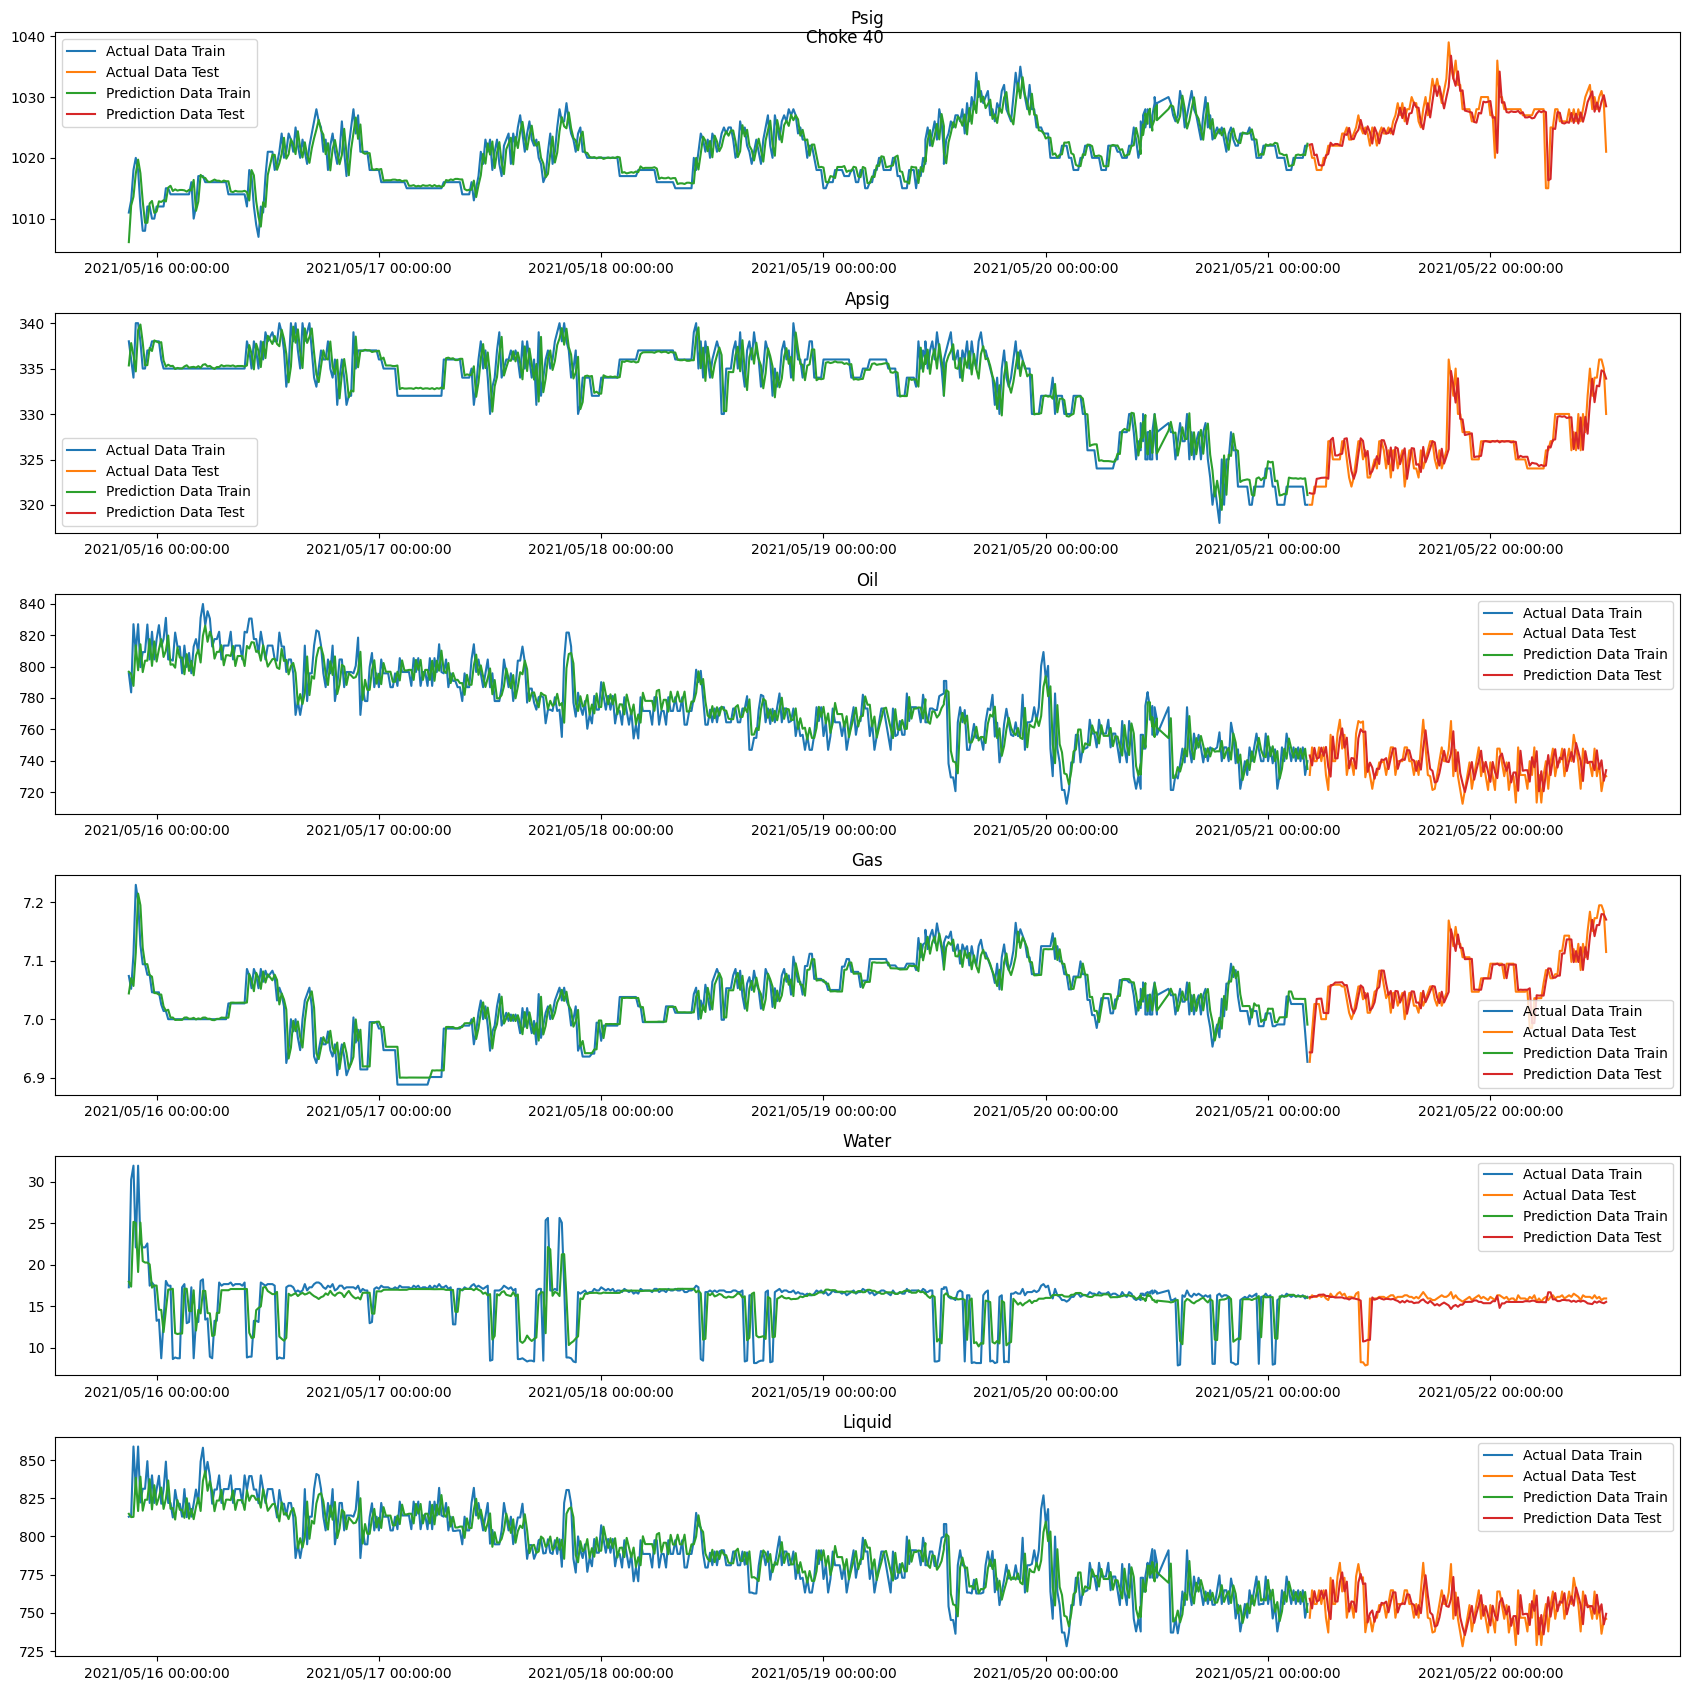

In [24]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_40_y.shape[1])

for i, ax in enumerate(axes):
    # Plot training data
    ax.plot(data['datetime'].iloc[:denormalized_train_40_y.shape[0]],
            denormalized_train_40_y.iloc[:, i], label='Actual Data Train')
    
    # Plot testing data
    ax.plot(data['datetime'].iloc[denormalized_train_40_y.shape[0]:denormalized_train_40_y.shape[0]+denormalized_test_40_y.shape[0]],
        denormalized_test_40_y.iloc[:, i], label='Actual Data Test')
    
    # Plot Prediction Training
    ax.plot(data['datetime'].iloc[:denormalized_train_40_y.shape[0]],
            denormalized_predictions_train_40.iloc[:, i], label='Prediction Data Train')
    
    # Plot predictions
    ax.plot(data['datetime'].iloc[denormalized_train_40_y.shape[0]:denormalized_train_40_y.shape[0]+denormalized_test_40_y.shape[0]],
            denormalized_predictions_40.iloc[:, i], label='Prediction Data Test')
    
    ax.set_title(denormalized_train_40_y.columns[i].capitalize())
    ax.legend()
    format_date_ticks(ax)

fig.tight_layout()
fig.suptitle('Choke 40')
fig.savefig('choke_40.png')
fig.show()

## 3. Data Choke 42

/tmp/ipykernel_23319/4128015334.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


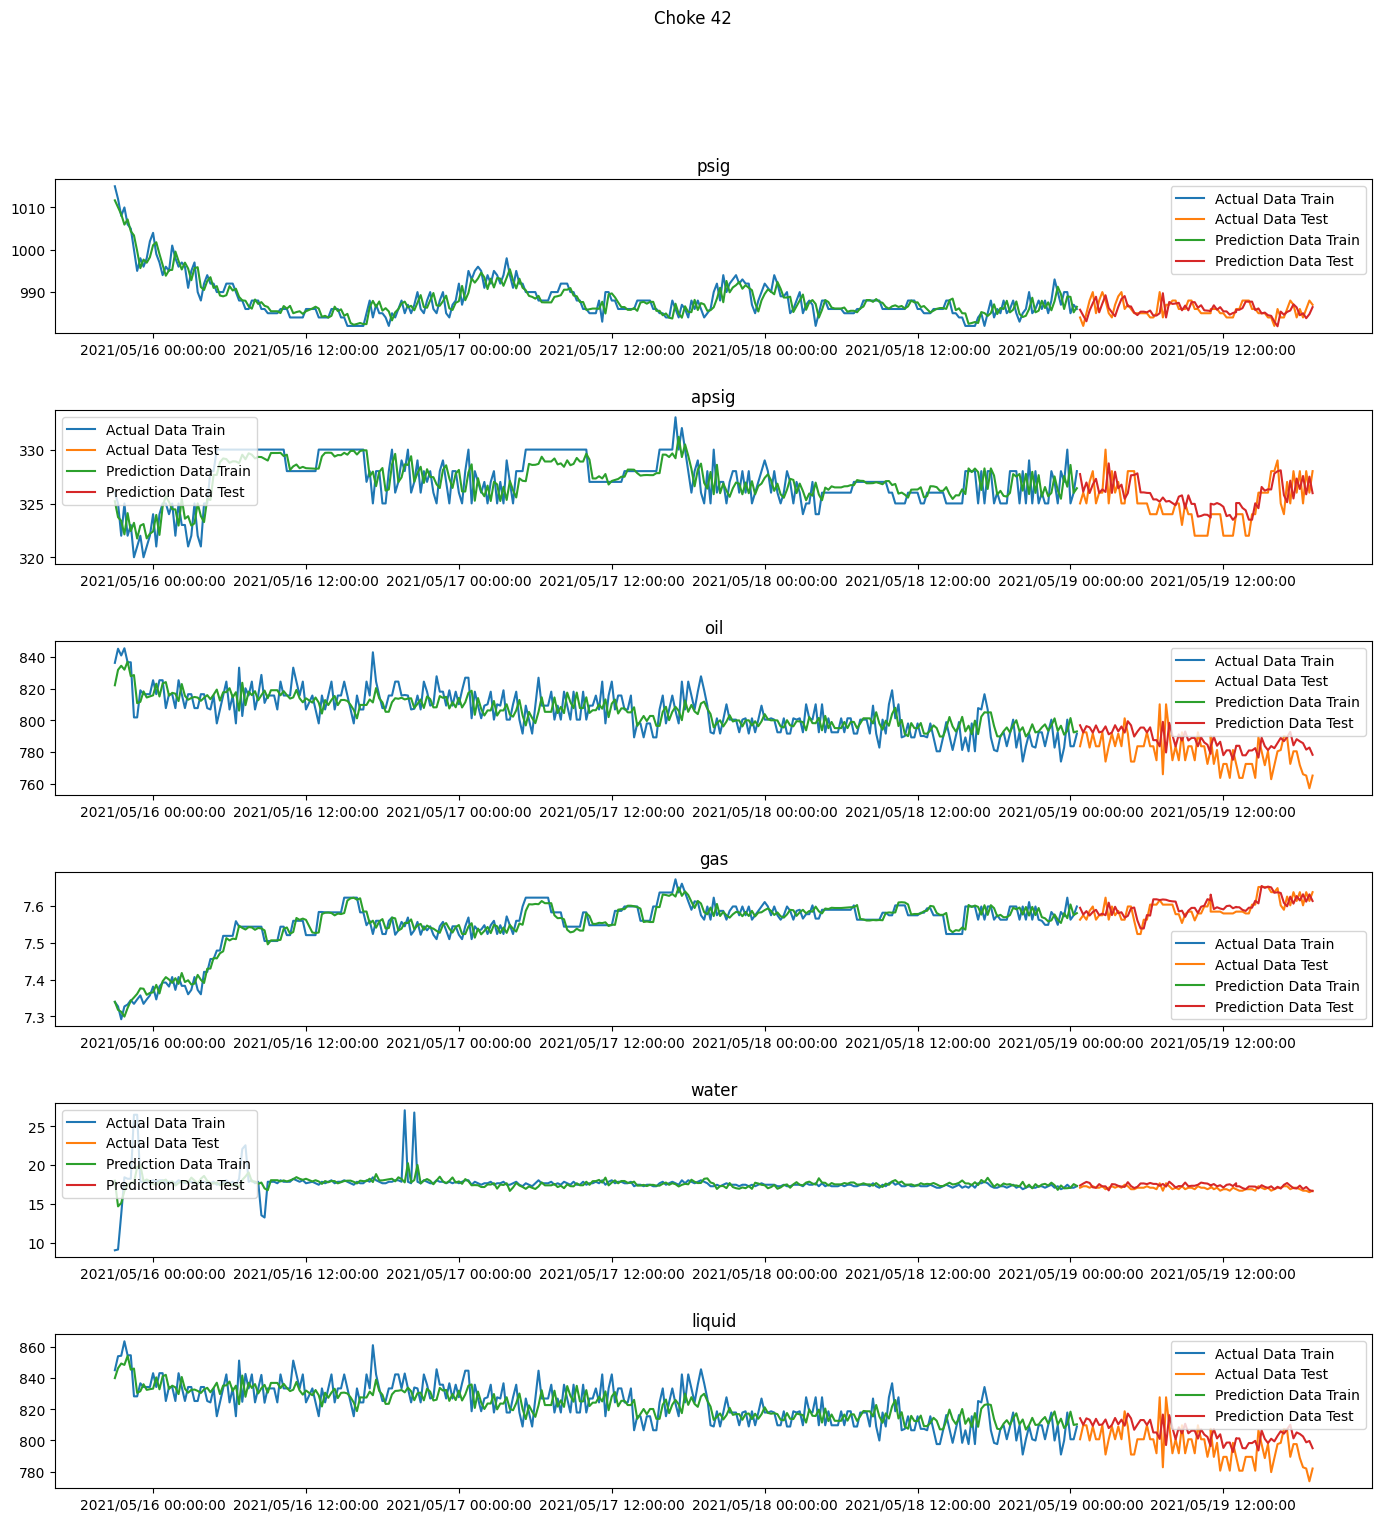

In [25]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_42_y.shape[1])

for i, ax in enumerate(axes):
    # Plot training data
    ax.plot(data['datetime'].iloc[:denormalized_train_42_y.shape[0]],
            denormalized_train_42_y.iloc[:, i], label='Actual Data Train')

    # Plot testing data
    ax.plot(data['datetime'].iloc[denormalized_train_42_y.shape[0]:denormalized_train_42_y.shape[0] + denormalized_test_42_y.shape[0]],
            denormalized_test_42_y.iloc[:, i], label='Actual Data Test')
    
    # Plot Prediction Training
    ax.plot(data['datetime'].iloc[:denormalized_train_42_y.shape[0]],
            denormalized_predictions_train_42.iloc[:, i], label='Prediction Data Train')

    # Plot predictions
    ax.plot(data['datetime'].iloc[denormalized_train_42_y.shape[0]:denormalized_train_42_y.shape[0] + denormalized_test_42_y.shape[0]],
            denormalized_predictions_42.iloc[:, i], label='Prediction Data Test')
    
    ax.set_title(denormalized_train_42_y.columns[i])
    ax.legend()
    format_date_ticks(ax)

fig.subplots_adjust(hspace=0.5)
fig.suptitle('Choke 42')
fig.savefig('choke_42.png')
fig.show()

## 4. Perbandingan Data Choke 38, 40, dan 42 pada setiap feature

/tmp/ipykernel_23319/1663093806.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].bar(prediction_sums.keys(), [prediction_sum_38[i], prediction_sum_40[i], prediction_sum_42[i]], color=['red', 'green', 'blue'])
/tmp/ipykernel_23319/1663093806.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


,Choke 38,Choke 40,Choke 42
psig,180582.781824,132404.966236,74930.880250
apsig,56665.113375,42131.165749,24754.640086
oil,128214.407869,95354.062883,59882.548990
gas,1107.009458,911.626642,577.649283
water,2356.797423,2001.163865,1318.460976
liquid,130540.595142,97330.700137,61200.631221


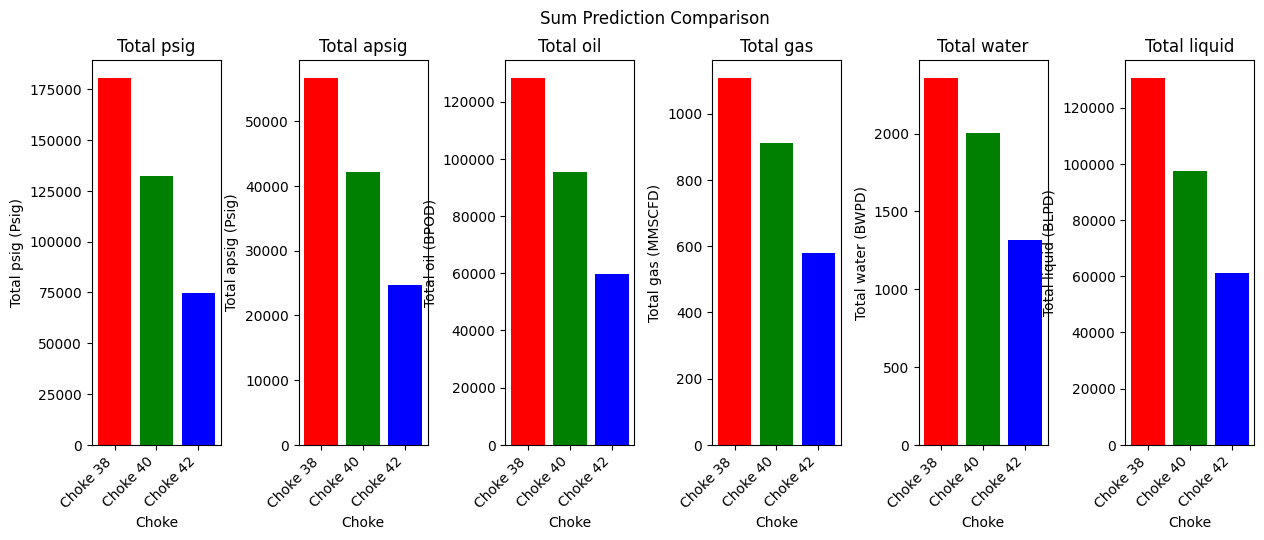

In [26]:
prediction_sum_38 = denormalized_predictions_38.sum()
prediction_sum_40 = denormalized_predictions_40.sum()
prediction_sum_42 = denormalized_predictions_42.sum()
prediction_sums = {
    'Choke 38': prediction_sum_38,
    'Choke 40': prediction_sum_40,
    'Choke 42': prediction_sum_42
}

units = ['Psig', 'Psig', 'BPOD', 'MMSCFD', 'BWPD', 'BLPD']

# plot sum prediction comparison bar
fig, axes = plt.subplots(figsize=(15, 5), ncols=len(prediction_sum_38.index))

for i, column in enumerate(prediction_sum_38.index):
    axes[i].bar(prediction_sums.keys(), [prediction_sum_38[i], prediction_sum_40[i], prediction_sum_42[i]], color=['red', 'green', 'blue'])
    axes[i].set_title('Total ' + column)
    axes[i].set_ylabel(f'Total {column} ({units[i]})')
    axes[i].set_xlabel('Choke')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

fig.subplots_adjust(wspace=0.6)
fig.suptitle('Sum Prediction Comparison')
fig.savefig('sum_prediction_comparison.png')
fig.show()

# display as table
pd.DataFrame(prediction_sums)

/tmp/ipykernel_23319/2160761858.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].bar(prediction_means.keys(), [prediction_mean_38[i], prediction_mean_40[i], prediction_mean_42[i]], color=['red', 'green', 'blue'])
/tmp/ipykernel_23319/2160761858.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


,Choke 38,Choke 40,Choke 42
psig,1056.039660,1026.395087,985.932635
apsig,331.374932,326.598184,325.718948
oil,749.791859,739.178782,787.928276
gas,6.473740,7.066873,7.600648
water,13.782441,15.512898,17.348171
liquid,763.395293,754.501551,805.271463


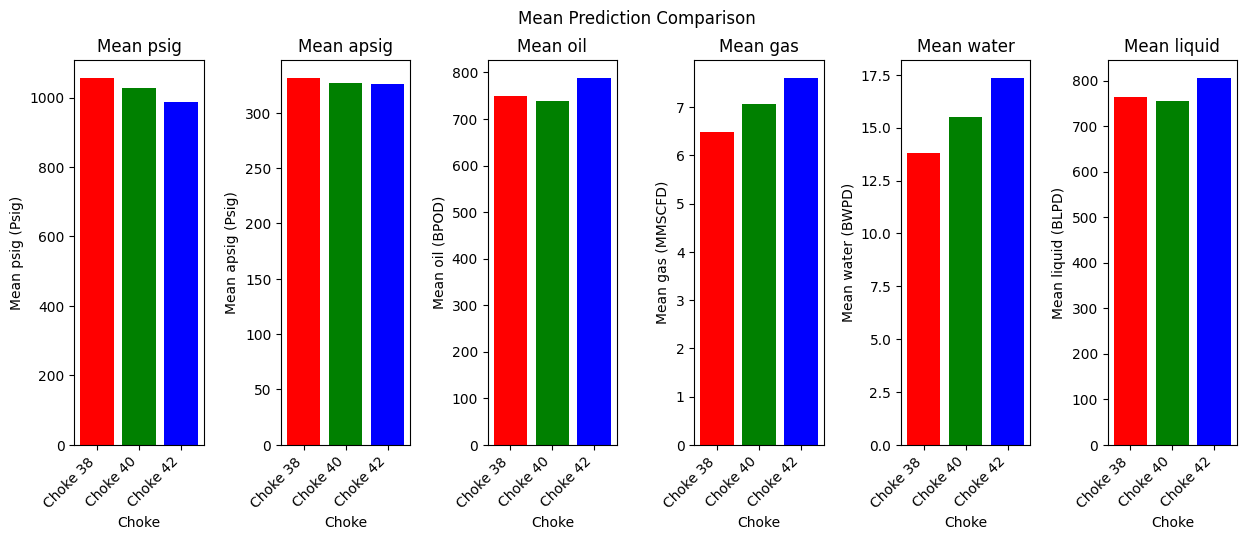

In [27]:
prediction_mean_38 = denormalized_predictions_38.mean()
prediction_mean_40 = denormalized_predictions_40.mean()
prediction_mean_42 = denormalized_predictions_42.mean()

prediction_means = {
    'Choke 38': prediction_mean_38,
    'Choke 40': prediction_mean_40,
    'Choke 42': prediction_mean_42
}

# plot mean prediction comparison bar
fig, axes = plt.subplots(figsize=(15, 5), ncols=len(prediction_mean_38.index))

for i, column in enumerate(prediction_mean_38.index):
    axes[i].bar(prediction_means.keys(), [prediction_mean_38[i], prediction_mean_40[i], prediction_mean_42[i]], color=['red', 'green', 'blue'])
    axes[i].set_title('Mean ' + column)
    axes[i].set_ylabel(f'Mean {column} ({units[i]})')
    axes[i].set_xlabel('Choke')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

fig.subplots_adjust(wspace=0.6)
fig.suptitle('Mean Prediction Comparison')
fig.savefig('mean_prediction_comparison.png')
fig.show()

# display as table
pd.DataFrame(prediction_means)

# M. Kombinasikan Semua Data Prediksi


In [28]:
predictions_all = pd.concat([denormalized_predictions_train_38, denormalized_predictions_38, denormalized_predictions_train_40, denormalized_predictions_40, denormalized_predictions_train_42, denormalized_predictions_42])
predictions_all.reset_index(drop=True, inplace=True)
predictions_all['choke'] = [38] * len(denormalized_predictions_train_38) + [38] * len(denormalized_predictions_38) + [40] * len(denormalized_predictions_train_40) + [40] * len(denormalized_predictions_40) + [42] * len(denormalized_predictions_train_42) + [42] * len(denormalized_predictions_42)
predictions_all['datetime'] = data['datetime']
# move choke and datetime to front
predictions_all = predictions_all[['datetime', 'choke'] + [col for col in predictions_all.columns if col not in ['datetime', 'choke']]]
predictions_all.to_csv('predictions_all.csv', index=False)
predictions_all

,datetime,choke,psig,apsig,oil,gas,water,liquid
0,2021-05-15 21:00:00,38,927.562897,317.624530,726.320541,4.962293,23.746341,750.124876
1,2021-05-15 21:15:00,38,929.967995,318.479935,806.597284,4.973696,29.768226,836.304452
2,2021-05-15 21:30:00,38,932.796165,316.717457,700.608676,5.058033,24.550722,725.267576
3,2021-05-15 21:45:00,38,932.923385,316.243730,750.207299,5.056897,26.576270,776.831646
4,2021-05-15 22:00:00,38,932.604112,317.340867,700.406732,5.062950,24.630022,725.132774
...,...,...,...,...,...,...,...,...
1870,2021-06-04 07:15:00,42,984.567382,326.348973,786.815612,7.615500,17.367695,804.176082
1871,2021-06-04 07:30:00,42,985.023666,327.554492,785.657283,7.632181,16.931551,802.582602
1872,2021-06-04 07:45:00,42,983.861248,325.849030,781.613682,7.612188,17.199470,798.811131
1873,2021-06-04 08:00:00,42,984.819261,327.496814,782.895341,7.631998,16.795674,799.686332


# N. Visualisasi Data Prediksi

/tmp/ipykernel_23319/2446948456.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


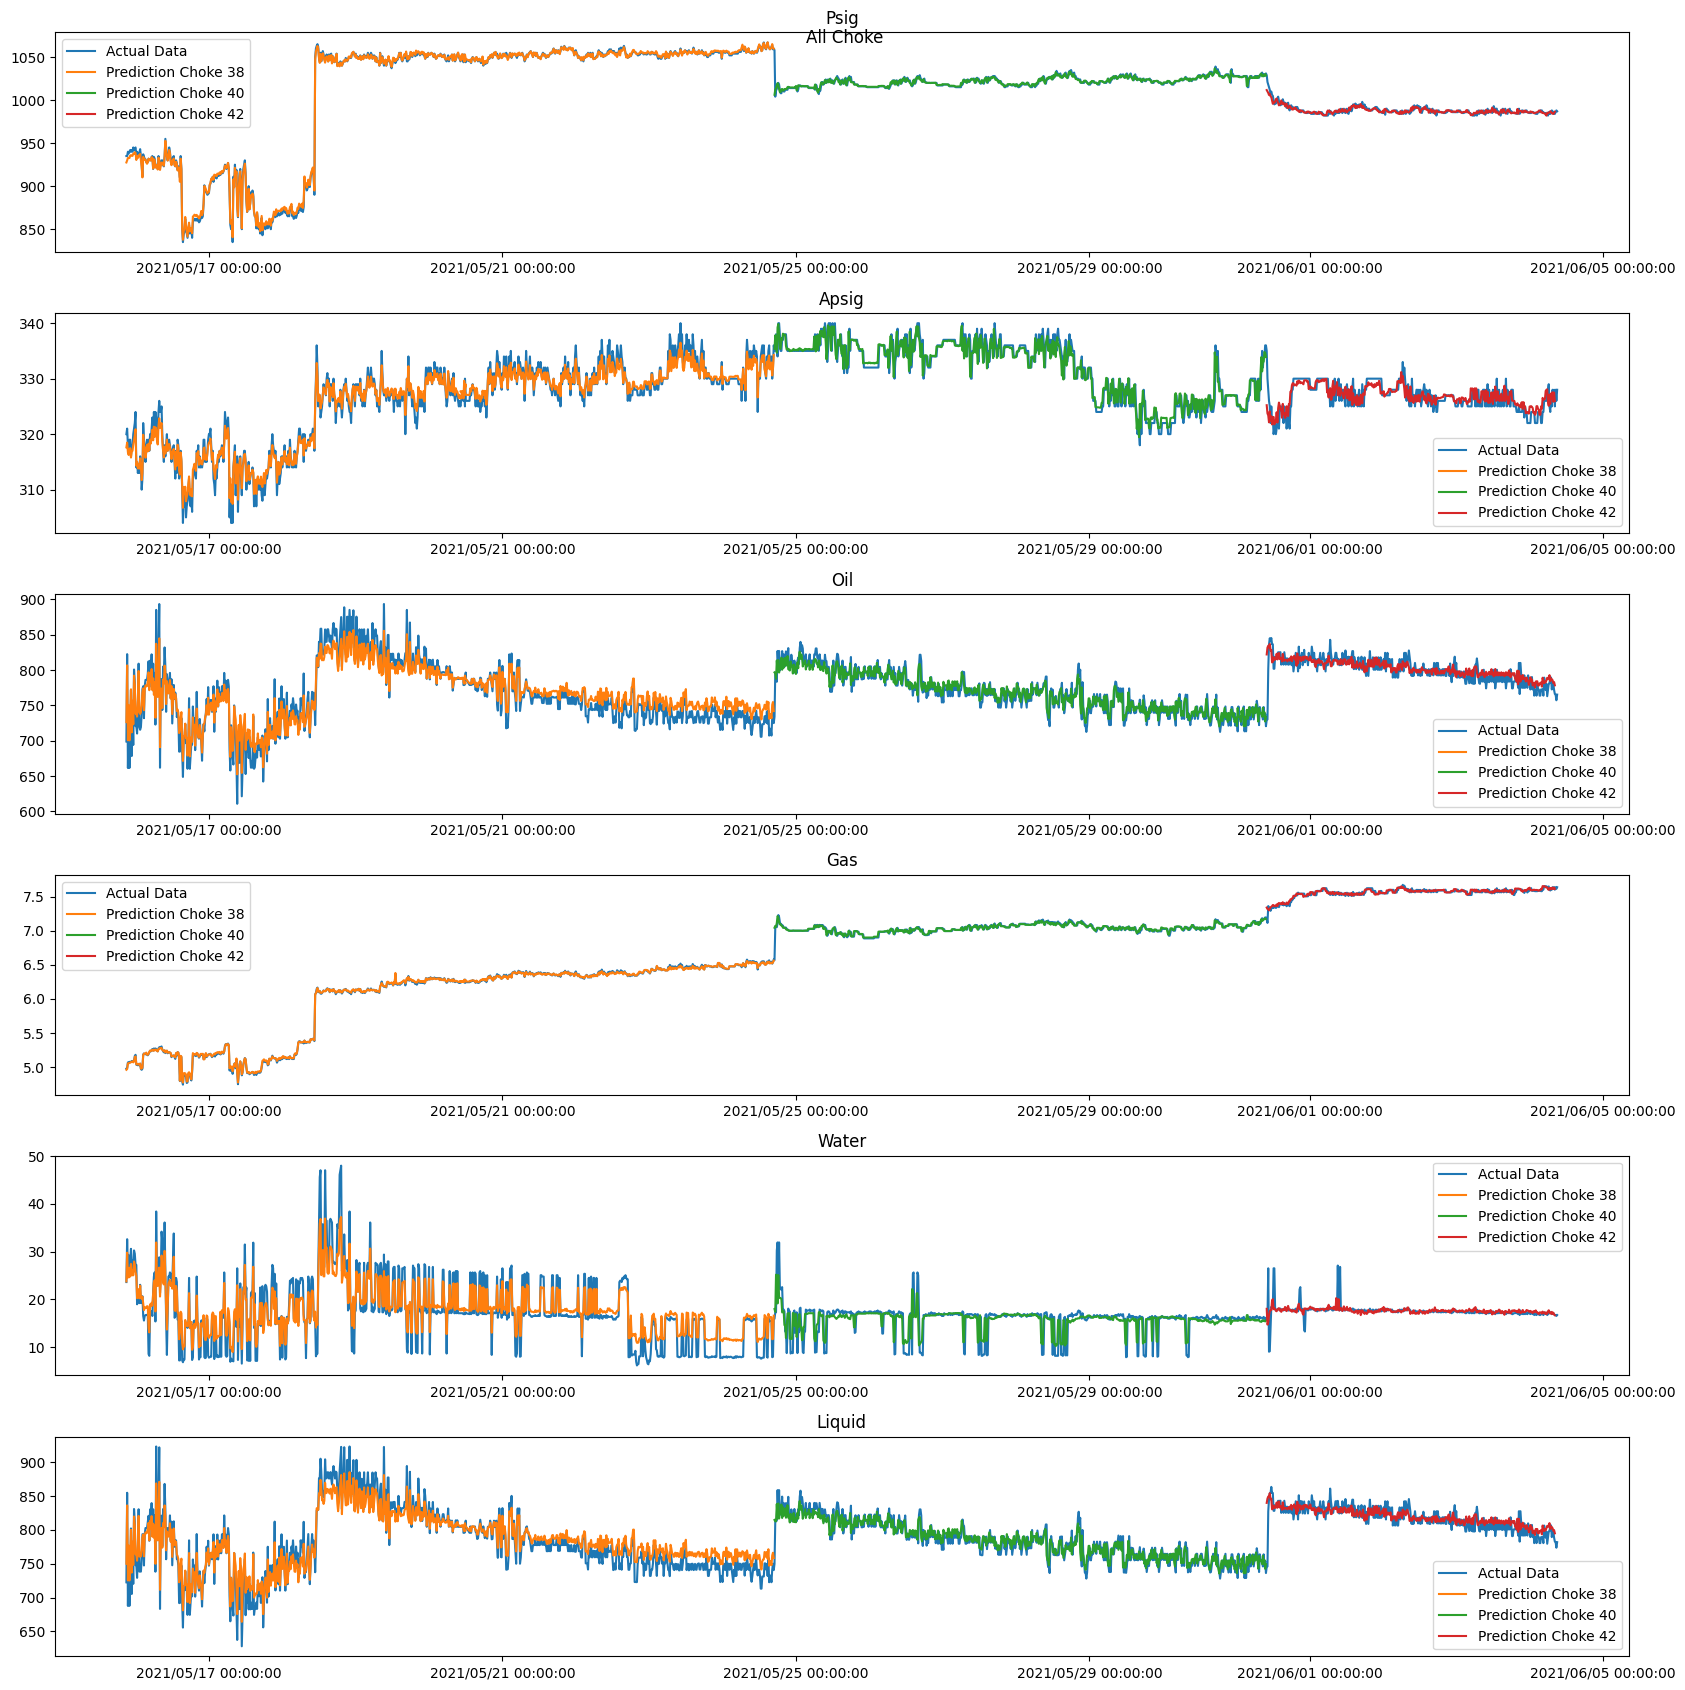

In [29]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_38_y.shape[1])
for i, ax in enumerate(axes):
    ax.plot(data['datetime'], data[data.columns[i+2]], label='Actual Data')

    for choke in [38, 40, 42]:
        ax.plot(predictions_all[predictions_all['choke'] == choke]['datetime'], predictions_all[predictions_all['choke'] == choke][predictions_all.columns[i+2]], label=f'Prediction Choke {choke}')

    ax.set_title(data.columns[i+2].capitalize())
    format_date_ticks(ax)
    ax.legend()
  
plt.tight_layout()
fig.suptitle('All Choke')
fig.savefig('all_choke.png')
fig.show()

# O. Ratio Liquid Output

In [30]:
predictions_all_date = predictions_all.copy()
predictions_all_date['date'] = predictions_all_date['datetime'].dt.date
predictions_all_date['week'] = predictions_all_date['datetime'].dt.isocalendar().week
predictions_all_date['month'] = predictions_all_date['datetime'].dt.month

# SUM
predictions_all_date_grouped_sum = predictions_all_date.drop(['week', 'month', 'liquid'], axis=1).groupby(['choke', 'date']).sum(numeric_only=True).reset_index()
# predictions_all_date_grouped_sum['liquid']
predictions_all_date_grouped_sum.to_csv('predictions_all_date_grouped_sum.csv', index=False)

predictions_all_week_grouped_sum = predictions_all_date.drop(['date', 'month', 'liquid'], axis=1).groupby(['choke', 'week']).sum(numeric_only=True).reset_index()
# predictions_all_week_grouped_sum['liquid']
predictions_all_week_grouped_sum.to_csv('predictions_all_week_grouped_sum.csv', index=False)

predictions_all_month_grouped_sum = predictions_all_date.drop(['week', 'date', 'liquid'], axis=1).groupby(['choke', 'month']).sum(numeric_only=True).reset_index()
# predictions_all_month_grouped_sum['liquid']
predictions_all_month_grouped_sum.to_csv('predictions_all_month_grouped_sum.csv', index=False)

# MEAN
predictions_all_date_grouped_mean = predictions_all_date.drop(['week', 'month', 'liquid'], axis=1).groupby(['choke', 'date']).mean(numeric_only=True).reset_index()
# predictions_all_date_grouped_mean['liquid']
predictions_all_date_grouped_mean.to_csv('predictions_all_date_grouped_mean.csv', index=False)

predictions_all_week_grouped_mean = predictions_all_date.drop(['date', 'month', 'liquid'], axis=1).groupby(['choke', 'week']).mean(numeric_only=True).reset_index()
# predictions_all_week_grouped_mean['liquid']
predictions_all_week_grouped_mean.to_csv('predictions_all_week_grouped_mean.csv', index=False)

predictions_all_month_grouped_mean = predictions_all_date.drop(['week', 'date', 'liquid'], axis=1).groupby(['choke', 'month']).mean(numeric_only=True).reset_index()
# predictions_all_month_grouped_mean['liquid']
predictions_all_month_grouped_mean.to_csv('predictions_all_month_grouped_mean.csv', index=False)

display(predictions_all_date_grouped_sum)
display(predictions_all_date_grouped_mean)
display(predictions_all_week_grouped_sum)
display(predictions_all_week_grouped_mean)
display(predictions_all_month_grouped_sum)
display(predictions_all_month_grouped_mean)

,choke,date,psig,apsig,oil,gas,water
0,38,2021-05-15,11212.607193,3810.240214,8953.943854,60.725259,314.034331
1,38,2021-05-16,86000.391092,30004.085373,70918.330670,487.801860,1739.338721
2,38,2021-05-17,85077.866974,30160.739716,69281.255939,487.860830,1529.931882
3,38,2021-05-18,93610.700773,30973.487458,75200.230268,550.869221,2107.414122
4,38,2021-05-19,102872.450689,32117.846434,79486.844017,608.506951,2019.915711
5,38,2021-05-20,104952.045112,32863.436409,78678.009048,628.097488,1893.664316
6,38,2021-05-21,101180.226120,31704.535755,74083.124252,610.857143,1778.866910
7,38,2021-05-22,101114.074958,31681.734791,72894.975180,611.046677,1630.671450
8,38,2021-05-23,101228.381050,31828.241217,72129.354346,619.691207,1357.599265
9,38,2021-05-24,71969.145863,22532.645007,50799.082295,442.389350,914.547356


,choke,date,psig,apsig,oil,gas,water
0,38,2021-05-15,934.383933,317.520018,746.161988,5.060438,26.169528
1,38,2021-05-16,905.267275,315.832478,746.508744,5.134756,18.308829
2,38,2021-05-17,886.227781,314.174372,721.679749,5.081884,15.936790
3,38,2021-05-18,975.111466,322.640494,783.335732,5.738221,21.952230
4,38,2021-05-19,1049.718885,327.733127,811.090245,6.209255,20.611385
5,38,2021-05-20,1049.520451,328.634364,786.780090,6.280975,18.936643
6,38,2021-05-21,1053.960689,330.255581,771.699211,6.363095,18.529864
7,38,2021-05-22,1053.271614,330.018071,759.322658,6.365070,16.986161
8,38,2021-05-23,1054.462303,331.544179,751.347441,6.455117,14.141659
9,38,2021-05-24,1058.369792,331.362427,747.045328,6.505726,13.449226


,choke,week,psig,apsig,oil,gas,water
0,38,19,97212.998285,33814.325587,79872.274524,548.527119,2053.373052
1,38,20,690035.745676,221330.021781,521753.793050,4116.929517,12318.063655
2,38,21,71969.145863,22532.645007,50799.082295,442.389350,914.547356
3,40,21,616952.384004,200626.366391,465114.496200,4248.813689,9507.423689
4,40,22,41071.058232,13123.284358,29488.744283,283.767551,625.527504
5,42,22,373468.787250,123547.415086,303285.080902,2857.436779,6653.576448


,choke,week,psig,apsig,oil,gas,water
0,38,19,908.532694,316.021734,746.469855,5.126422,19.190402
1,38,20,1017.751837,326.445460,769.548367,6.072167,18.168235
2,38,21,1058.369792,331.362427,747.045328,6.505726,13.449226
3,40,21,1021.444344,332.162858,770.057113,7.034460,15.740768
4,40,22,1026.776456,328.082109,737.218607,7.094189,15.638188
5,42,22,988.012665,326.845013,802.341484,7.559357,17.602054


,choke,month,psig,apsig,oil,gas,water
0,38,5,859217.889824,277676.992375,652425.149869,5107.845986,15285.984063
1,40,5,658023.442236,213749.650749,494603.240483,4532.581240,10132.951193
2,42,5,55657.247045,18261.105811,45803.663450,416.571995,995.737372
3,42,6,317811.540205,105286.309275,257481.417452,2440.864784,5657.839076


,choke,month,psig,apsig,oil,gas,water
0,38,5,1007.289437,325.529886,764.859496,5.988096,17.920263
1,40,5,1021.775531,331.909396,768.017454,7.038170,15.734396
2,42,5,993.879412,326.091175,817.922562,7.438786,17.781025
3,42,6,986.992361,326.976116,799.631731,7.580325,17.570929
